In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from dataGenerator import toy_set_gen
from plot_graph import show_graph

1.0418262e-10


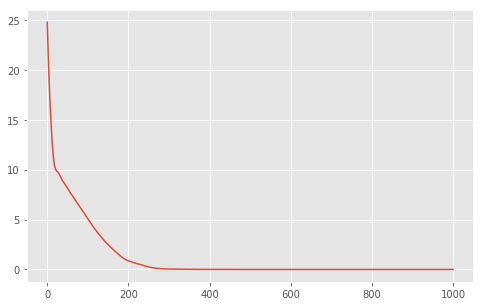

In [72]:
tf.reset_default_graph()

BATCHSIZE = 10
data_interval = 16
channels = 1

gen = toy_set_gen(data_interval, channels)
dataset = tf.data.Dataset.from_generator(gen,
                                         output_types = (tf.float32, tf.float32),
                                         output_shapes=(tf.TensorShape([None, data_interval, channels]), tf.TensorShape([1])))
dataset = dataset.padded_batch(BATCHSIZE,
                               (tf.TensorShape([None,data_interval,channels]), 
                                tf.TensorShape([1]))).repeat().shuffle(10)
data_iter = dataset.make_initializable_iterator()

X, y = data_iter.get_next()
    
# conv - conv - pool
C1 = tf.layers.conv2d(X, 2, [1,3], [1,1], padding="same")
A1 = tf.nn.relu(C1)
P1 = tf.nn.max_pool(A1, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
# batch x ? x N/2 x 8

sh = tf.shape(P1)
vectors = tf.reshape(P1, [sh[0], sh[1], 16])
D1 = tf.layers.dense(vectors, 8)
A2 = tf.nn.relu(D1)
inp_sum = tf.reduce_sum(A2, axis=1)
# FC net
D2 = tf.layers.dense(inp_sum, 8)
A3 = tf.nn.relu(D2)
model_output = tf.layers.dense(A3, 1)
    
loss = tf.reduce_mean((model_output - y)**2)

opt = tf.train.AdamOptimizer(learning_rate=1.0e-3)
train_step = opt.minimize(loss)
grads = opt.compute_gradients(loss)

sess = tf.Session()
lh = []

sess.run(tf.global_variables_initializer())
sess.run(data_iter.initializer)
for i in range(1000):
    v, t, l = sess.run([model_output, y, loss])
    sess.run(train_step)
    lh.append(l)

plt.figure(figsize=(8,5))    
plt.plot(lh)
print(l)

[5.06734]


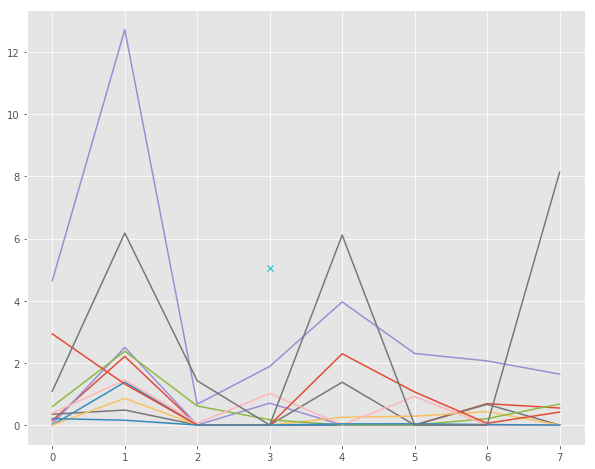

In [82]:
# show_graph(loss.graph)
i=6
a, s, d, o, t = sess.run([A2, inp_sum, A3, model_output, y])
print(t[i])
plt.figure(figsize=(10,8))
plt.plot(a[i].T)
plt.plot(s[i])
plt.plot(d[i])
plt.plot(3,o[i], 'cx')
plt.show()